In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [3]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512"))

['val', 'test', 'train']


In [4]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = tf.cast(example["class"], tf.uint16)
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    return image


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord
    )  # a dataset of (image, label) pairs if labeled=True or (image) if labeled=False
    for elem in maped_dataset:
        yield elem


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath


def load_tensor_batches(generator_dataset, batch_size=64):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in train_trf_dataset:
        batch_imgs.append(
            torch.tensor(elem[0].numpy().astype(float) / 255.0, dtype=torch.float16).permute(
                2, 0, 1
            )
        )
        batch_lbls.append(torch.tensor(elem[1].numpy(), dtype=torch.float16))
        i += 1
        if i % batch_size == 0:
            yield torch.stack(batch_imgs), torch.stack(batch_lbls)
            batch_imgs, batch_lbls = list(), list()

In [5]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [6]:
train_trf_dataset

<generator object load_dataset at 0x7a67a9bb8200>

In [7]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512"
train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

batch_train_tensors = next(load_tensor_batches(train_trf_dataset))

In [8]:
batch_train_tensors[0].shape

torch.Size([64, 3, 512, 512])

tensor(68., dtype=torch.float16)


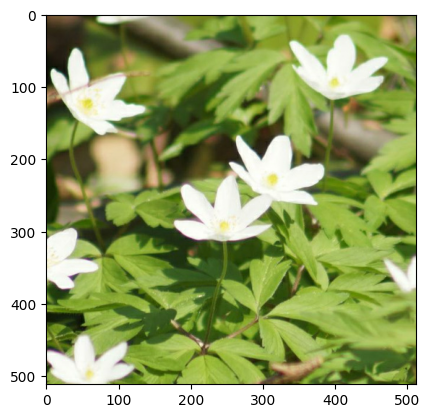

In [9]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [10]:
xm.get_xla_supported_devices()

E0000 00:00:1724676279.430300   19739 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


['xla:0', 'xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7']

In [11]:
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
device

device(type='xla', index=0)

In [12]:
import math

import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm


class xml_fully_connected(nn.Module):
    def __init__(self, batch_size=(64, 3, 512, 512)) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(math.prod(batch_size[1:]), 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 104),
        )

    def forward(self, batch):
        return self.model(batch.view(batch.shape[0], -1))

In [14]:
from sklearn import metrics


xml_model = xml_fully_connected(batch_train_tensors[0].shape).to(device)

num_epochs = 100
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(xml_model.parameters(), lr=5e-3)

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for batch in load_tensor_batches(load_dataset(get_recursive_paths(path, "train"))):
        opt.zero_grad()
        batch_img_tensor, batch_lbl_tensor = batch[0].to(device), batch[1].to(device)

        lbl_predict = xml_model(batch_img_tensor)
        output = loss(lbl_predict, batch_lbl_tensor)
        output.backward()
        opt.step()

        print(f"Loss: {output.detach().cpu()}")

        predictions = torch.argmax(lbl_predict, dim=1).detach().cpu().numpy()
        f1 = metrics.f1_score(
            batch_lbl_tensor.detach().cpu().numpy(), predictions, average="macro"
        )
        print(f"F1-score: {f1}")

        print(torch_xla.core.xla_model.get_memory_info(xm.xla_device()))

Epoch: 0
Loss: 4.624204158782959
F1-score: 0.0
Loss: 1102.28857421875
F1-score: 0.0039169604386995694
Loss: 436.94818115234375
F1-score: 0.0
Loss: 269.6744689941406
F1-score: 0.003676470588235294
Loss: 195.9876251220703
F1-score: 0.0034602076124567475
Loss: 132.16693115234375
F1-score: 0.0
Loss: 136.74960327148438
F1-score: 0.0
Loss: 104.532470703125
F1-score: 0.001594896331738437
Loss: 100.5571517944336
F1-score: 0.0008710801393728223
Loss: 68.34906768798828
F1-score: 0.0
Loss: 60.770111083984375
F1-score: 0.0007326007326007326
Loss: 39.68760299682617
F1-score: 0.0027137042062415195
Loss: 24.504812240600586
F1-score: 0.0
Loss: 14.331354141235352
F1-score: 0.005698005698005697
Loss: 19.08931541442871
F1-score: 0.0
Loss: 11.096546173095703
F1-score: 0.001488095238095238
Loss: 8.26251220703125
F1-score: 0.0016891891891891893
Loss: 6.244032859802246
F1-score: 0.0
Loss: 6.679091453552246
F1-score: 0.0
Loss: 5.235740661621094
F1-score: 0.0
Loss: 4.673817157745361
F1-score: 0.006349206349206

RuntimeError: Bad StatusOr access: RESOURCE_EXHAUSTED: XLA:TPU compile permanent error. Ran out of memory in memory space hbm. Used 15.49G of 15.48G hbm. Exceeded hbm capacity by 9.44M.

Total hbm usage >= 16.01G:
    reserved        530.00M 
    program           9.87G 
    arguments         5.62G 

Output size 2.0K; shares 0B with arguments.

Program hbm requirement 9.87G:
    HLO temp          9.85G (100.0% utilization: Unpadded (9.85G) Padded (9.85G), 0.1% fragmentation (6.22M))
    overlays         13.57M

  Largest program allocations in hbm:

  1. Size: 1.50G
     Shape: f32[512,786432]{1,0:T(8,128)}
     Unpadded size: 1.50G
     XLA label: fusion.118 = fusion(get-tuple-element.471, get-tuple-element.385, custom-call.1, copy.88, ...(+4)), kind=kOutput, calls=fused_computation.118
     Allocation type: HLO temp
     ==========================

  2. Size: 1.50G
     Shape: f32[512,786432]{1,0:T(8,128)}
     Unpadded size: 1.50G
     XLA label: fusion.118 = fusion(get-tuple-element.471, get-tuple-element.385, custom-call.1, copy.88, ...(+4)), kind=kOutput, calls=fused_computation.118
     Allocation type: HLO temp
     ==========================

  3. Size: 1.50G
     Shape: f32[512,786432]{1,0:T(8,128)}
     Unpadded size: 1.50G
     XLA label: fusion.134 = fusion(get-tuple-element.519, custom-call.1, copy.88, fusion.4225, ...(+6)), kind=kOutput, calls=fused_computation.134
     Allocation type: HLO temp
     ==========================

  4. Size: 1.50G
     Shape: f32[512,786432]{1,0:T(8,128)}
     Unpadded size: 1.50G
     XLA label: fusion.134 = fusion(get-tuple-element.519, custom-call.1, copy.88, fusion.4225, ...(+6)), kind=kOutput, calls=fused_computation.134
     Allocation type: HLO temp
     ==========================

  5. Size: 1.50G
     Shape: f32[512,786432]{1,0:T(8,128)}
     Unpadded size: 1.50G
     XLA label: fusion.305 = fusion(custom-call.21, copy.78, copy.44, custom-call.1, ...(+11)), kind=kOutput, calls=fused_computation.303
     Allocation type: HLO temp
     ==========================

  6. Size: 768.00M
     Shape: f16[512,786432]{1,0:T(8,128)(2,1)}
     Unpadded size: 768.00M
     XLA label: fusion.307 = fusion(get-tuple-element.404, get-tuple-element.403, custom-call.17, copy.80, ...(+9)), kind=kOutput, calls=fused_computation.305
     Allocation type: HLO temp
     ==========================

  7. Size: 768.00M
     Shape: f16[512,786432]{1,0:T(8,128)(2,1)}
     Unpadded size: 768.00M
     XLA label: fusion.4225 = fusion(get-tuple-element.511, bitcast.39), kind=kOutput, calls=fused_computation.3595
     Allocation type: HLO temp
     ==========================

  8. Size: 768.00M
     Shape: f16[512,786432]{1,0:T(8,128)(2,1)}
     Unpadded size: 768.00M
     XLA label: fusion.305 = fusion(custom-call.21, copy.78, copy.44, custom-call.1, ...(+11)), kind=kOutput, calls=fused_computation.303
     Allocation type: HLO temp
     ==========================

  9. Size: 96.00M
     Shape: f16[8,8,1536,512]{3,1,2,0:T(8,128)(2,1)}
     Unpadded size: 96.00M
     XLA label: copy.11 = copy(bitcast.46)
     Allocation type: HLO temp
     ==========================

  10. Size: 13.57M
     XLA label: overlays
     Allocation type: overlays
     ==========================

  11. Size: 512.0K
     Shape: f32[256,512]{1,0:T(8,128)}
     Unpadded size: 512.0K
     XLA label: fusion.477 = fusion(get-tuple-element.508, custom-call.21, copy.78, copy.44, ...(+8)), kind=kOutput, calls=fused_computation.450
     Allocation type: HLO temp
     ==========================

  12. Size: 512.0K
     Shape: f32[256,512]{1,0:T(8,128)}
     Unpadded size: 512.0K
     XLA label: fusion.477 = fusion(get-tuple-element.508, custom-call.21, copy.78, copy.44, ...(+8)), kind=kOutput, calls=fused_computation.450
     Allocation type: HLO temp
     ==========================

  13. Size: 512.0K
     Shape: f32[256,512]{1,0:T(8,128)}
     Unpadded size: 512.0K
     XLA label: fusion.477 = fusion(get-tuple-element.508, custom-call.21, copy.78, copy.44, ...(+8)), kind=kOutput, calls=fused_computation.450
     Allocation type: HLO temp
     ==========================

  14. Size: 128.0K
     Shape: f32[64,512]{1,0:T(8,128)}
     Unpadded size: 128.0K
     XLA label: fusion.640 = fusion(bitcast.47, get-tuple-element.518, fusion.2858), kind=kOutput, calls=fused_computation.612
     Allocation type: HLO temp
     ==========================

  15. Size: 128.0K
     Shape: f32[128,256]{1,0:T(8,128)}
     Unpadded size: 128.0K
     XLA label: fusion.778 = fusion(get-tuple-element.506, custom-call.21, copy.78, copy.44, ...(+8)), kind=kOutput, calls=fused_computation.750
     Allocation type: HLO temp
     ==========================

  16. Size: 128.0K
     Shape: f32[128,256]{1,0:T(8,128)}
     Unpadded size: 128.0K
     XLA label: fusion.778 = fusion(get-tuple-element.506, custom-call.21, copy.78, copy.44, ...(+8)), kind=kOutput, calls=fused_computation.750
     Allocation type: HLO temp
     ==========================

  17. Size: 128.0K
     Shape: f32[128,256]{1,0:T(8,128)}
     Unpadded size: 128.0K
     XLA label: fusion.778 = fusion(get-tuple-element.506, custom-call.21, copy.78, copy.44, ...(+8)), kind=kOutput, calls=fused_computation.750
     Allocation type: HLO temp
     ==========================

  18. Size: 64.0K
     Shape: f32[64,256]{1,0:T(8,128)}
     Unpadded size: 64.0K
     XLA label: fusion.1074 = fusion(get-tuple-element.305, fusion.640, get-tuple-element.302), kind=kOutput, calls=fused_computation.982
     Allocation type: HLO temp
     ==========================

  19. Size: 64.0K
     Shape: f16[64,512]{1,0:T(8,128)(2,1)}
     Unpadded size: 64.0K
     XLA label: fusion.4086 = fusion(get-tuple-element.537, get-tuple-element.305, fusion.640), kind=kOutput, calls=fused_computation.3460
     Allocation type: HLO temp
     ==========================

  20. Size: 52.0K
     Shape: f32[104,128]{1,0:T(8,128)}
     Unpadded size: 52.0K
     XLA label: fusion.1597 = fusion(get-tuple-element.504, custom-call.21, copy.78, copy.44, ...(+14)), kind=kOutput, calls=fused_computation.1437
     Allocation type: HLO temp
     ==========================

